In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.decomposition import PCA
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, Flatten, Conv1D
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from scipy.signal import lfilter
import solverFunctions as sf
import analysisFunctions as af
from scipy.interpolate import LinearNDInterpolator

In [3]:
def GetFlow(order_bc,continuous=False):
    if continuous:
        con_str = "C"
    else:
        con_str = "DC"
    u = np.load(r"DataDC/dataset"+con_str+"_u_30_1_"+str(order_bc)+".npy")
    v = np.load(r"DataDC/dataset"+con_str+"_v_30_1_"+str(order_bc)+".npy")
    p = np.load(r"DataDC/dataset"+con_str+"_p_30_1_"+str(order_bc)+".npy")
    return u,v,p

data = list(zip(GetFlow(1),GetFlow(2),GetFlow(3),GetFlow(5),GetFlow(4,True)))
# data = list(zip(GetFlow(1),GetFlow(2),GetFlow(3),GetFlow(5)))
# data = list(zip(GetFlow(4,True)))
u = np.concatenate(data[0],axis=0)
v = np.concatenate(data[1],axis=0)
p = np.concatenate(data[2],axis=0)
p = p-np.expand_dims(p.mean((1,2)),axis=(1,2))

p.shape

(27066, 30, 30)

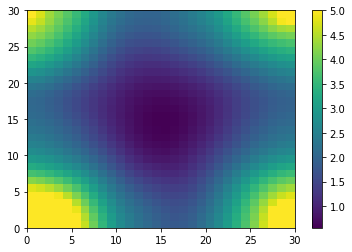

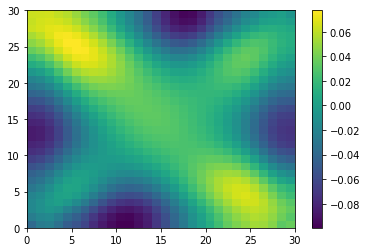

In [3]:
plt.pcolormesh(p.var(0),vmax=5)
plt.colorbar()
plt.show()
plt.pcolormesh(p.mean(0))
plt.colorbar()
plt.show()

In [4]:
def GetEncoderStaggered(n_latent,input_shapes):
    input_u = Input(shape=input_shapes[0], name='input_u')
    input_v = Input(shape=input_shapes[1], name='input_v')
    input_p = Input(shape=input_shapes[2], name='input_p')
    x_u = Flatten()(input_u)
    x_v = Flatten()(input_v)
    x_p = Flatten()(input_p)
    x = Concatenate()([x_u,x_v,x_p])
    latent = Dense(n_latent)(x)
    encoder = Model([input_u,input_v,input_p],latent,name="encoder")
    return encoder,input_u,input_v,input_p,latent

def GetDecoderStaggered(n_latent,input_shapes,latent):
    # input_latent = Input(shape=(n_latent,))
    input_latent = latent
    output_u = Dense(np.prod(input_shapes[0]),use_bias=False)(input_latent)
    output_u = Reshape(input_shapes[0],name="output_u")(output_u)
    output_v = Dense(np.prod(input_shapes[1]),use_bias=False)(input_latent)
    output_v = Reshape(input_shapes[1],name="output_v")(output_v)
    output_p = Dense(np.prod(input_shapes[2]),use_bias=False)(input_latent)
    output_p = Reshape(input_shapes[2],name="output_p")(output_p)
    decoder = Model(input_latent,[output_u,output_v,output_p],name="decoder")
    return decoder,input_latent,output_u,output_v,output_p

def GetAEStaggered(input_shapes,n_latent):
    encoder,input_u,input_v,input_p,latent = GetEncoderStaggered(n_latent,input_shapes)
    decoder,input_latent,output_u,output_v,output_p = GetDecoderStaggered(n_latent,input_shapes,latent)
    model = Model([input_u,input_v,input_p], [output_u,output_v,output_p],name="model_staggered")
    
    return model, encoder, decoder

def GetEncoderStaggeredNL(n_latent,input_shapes,nodes):
    input_u = Input(shape=input_shapes[0], name='input_u')
    x_u = Flatten()(input_u)
    input_v = Input(shape=input_shapes[1], name='input_v')
    x_v = Flatten()(input_v)
    input_p = Input(shape=input_shapes[2], name='input_p')
    x_p = Flatten()(input_p)

    for i in range(len(nodes[0])):
        x_u = Dense(nodes[0][i],activation='sigmoid')(x_u)
        x_u = BatchNormalization()(x_u)

        x_v = Dense(nodes[0][i],activation='sigmoid')(x_v)
        x_v = BatchNormalization()(x_v)

        x_p = Dense(nodes[0][i],activation='sigmoid')(x_p)
        x_p = BatchNormalization()(x_p)
    
    x = Concatenate()([x_u,x_v,x_p])
    for i in range(len(nodes[1])):
        x = Dense(nodes[1][i],activation='sigmoid')(x)
        if (i < len(nodes[1])-1):
            x = BatchNormalization()(x)

    latent = Dense(n_latent,name='latent_linear')(x)
    encoder = Model([input_u,input_v,input_p],latent,name="encoder")
    return encoder,input_u,input_v,input_p,latent

def GetDecoderStaggeredNL(n_latent,input_shapes,latent,nodes):
    # input_latent = Input(shape=(n_latent,))
    x = latent
    for i in range(len(nodes[1])-1,-1,-1):
        x = Dense(nodes[1][i],activation='sigmoid')(x)
        x = BatchNormalization()(x)

    x_u,x_v,x_p = x,x,x
    for i in range(len(nodes[0])-1,-1,-1):
        x_u = Dense(nodes[0][i],activation='sigmoid')(x_u)
        x_u = BatchNormalization()(x_u)

        x_v = Dense(nodes[0][i],activation='sigmoid')(x_v)
        x_v = BatchNormalization()(x_v)

        x_p = Dense(nodes[0][i],activation='sigmoid')(x_p)
        x_p = BatchNormalization()(x_p)
    
    output_u = Dense(np.prod(input_shapes[0]))(x_u)
    output_u = Reshape(input_shapes[0],name="output_u")(output_u)

    output_v = Dense(np.prod(input_shapes[1]))(x_v)
    output_v = Reshape(input_shapes[1],name="output_v")(output_v)

    output_p = Dense(np.prod(input_shapes[2]))(x_p)
    output_p = Reshape(input_shapes[2],name="output_p")(output_p)

    decoder = Model(x,[output_u,output_v,output_p],name="decoder")
    return decoder,x,output_u,output_v,output_p

def GetAEStaggeredNL(input_shapes,n_latent,nodes=[[100,100],[100,100]]):
    encoder,input_u,input_v,input_p,latent = GetEncoderStaggeredNL(n_latent,input_shapes,nodes)
    decoder,input_latent,output_u,output_v,output_p = GetDecoderStaggeredNL(n_latent,input_shapes,latent,nodes)
    model = Model([input_u,input_v,input_p], [output_u,output_v,output_p],name="model_staggered")
    
    return model, encoder, decoder

# n_latent = 10
# input_shapes = (u[0].shape,v[0].shape,p[0].shape)
# modelNL, encoderNL, decoderNL = GetAEStaggeredNL(input_shapes,n_latent,[[],[200,100]])
# tf.keras.utils.plot_model(modelNL, show_shapes=True)

In [8]:
# model, encoder, decoder = GetAEStaggeredNL(input_shapes,n_latent,[[],[100,100]])
# model, encoder, decoder = GetAEStaggeredNL(input_shapes,n_latent)
# model, encoder, decoder = GetAEStaggered(input_shapes,n_latent)
# optimizer = tf.keras.optimizers.Adadelta(0.001)
# optimizer = tf.keras.optimizers.Adam(0.001)
def con_res_loss(u,v,prob):
    mp_e = prob.rho*prob.dy_p*u[:,1:,1:-1]
    mp_w = prob.rho*prob.dy_p*u[:,:-1,1:-1]
    mp_n = prob.rho*prob.dx_p*v[:,1:-1,1:]
    mp_s = prob.rho*prob.dx_p*v[:,1:-1,:-1]
    dmp = mp_w+mp_s-mp_e-mp_n
    dmp = dmp*(prob.dx_p*prob.dy_p)
    con_res = tf.reduce_sum(tf.square(dmp),axis=(1,2))
    return con_res

def u_res_loss(u,v,p,prob):
    mu_e = prob.rho*prob.dy_u*(u[:,1:-1,1:-1]+u[:,2:,1:-1])/2
    mu_w = prob.rho*prob.dy_u*(u[:,:-2,1:-1]+u[:,1:-1,1:-1])/2
    mu_n = prob.rho*prob.dx_u*(v[:,1:-2,1:]+v[:,2:-1,1:])/2
    mu_s = prob.rho*prob.dx_u*(v[:,1:-2,:-1]+v[:,2:-1,:-1])/2
    convection = -(mu_e*(u[:,2:,1:-1]+u[:,1:-1,1:-1])/2\
    + mu_n*(u[:,1:-1,2:]+u[:,1:-1,1:-1])/2\
    - mu_w*(u[:,:-2,1:-1]+u[:,1:-1,1:-1])/2\
    - mu_s*(u[:,1:-1,:-2]+u[:,1:-1,1:-1])/2)
    diffusion = prob.Aud_x[:-1,:]*(u[:,1:-1,1:-1]-u[:,:-2,1:-1]) + prob.Aud_x[1:,:]*(u[:,1:-1,1:-1]-u[:,2:,1:-1]) +\
        prob.Aud_y[:,:-1]*(u[:,1:-1,1:-1]-u[:,1:-1,:-2]) + prob.Aud_y[:,1:]*(u[:,1:-1,1:-1]-u[:,1:-1,2:])
    pressure = prob.dy_u*(p[:,1:,:]-p[:,:-1,:])
    # u_res_CV = (convection-diffusion-pressure)*(prob.dx_u*prob.dy_u)
    # u_res = tf.reduce_mean(tf.square(u_res_CV),axis=(1,2))
    u_res = tf.reduce_sum(tf.square(convection-diffusion-pressure),axis=(1,2))
    return u_res

def v_res_loss(u,v,p,prob):
    mv_e = prob.rho*prob.dy_v*(u[:,1:,1:-2]+u[:,1:,2:-1])/2
    mv_w = prob.rho*prob.dy_v*(u[:,:-1,1:-2]+u[:,:-1,2:-1])/2
    mv_n = prob.rho*prob.dx_v*(v[:,1:-1,1:-1]+v[:,1:-1,2:])/2
    mv_s = prob.rho*prob.dx_v*(v[:,1:-1,1:-1]+v[:,1:-1,:-2])/2
    convection = -(mv_e*(v[:,2:,1:-1]+v[:,1:-1,1:-1])/2\
    + mv_n*(v[:,1:-1,2:]+v[:,1:-1,1:-1])/2\
    - mv_w*(v[:,:-2,1:-1]+v[:,1:-1,1:-1])/2\
    - mv_s*(v[:,1:-1,:-2]+v[:,1:-1,1:-1])/2)
    diffusion = prob.Avd_x[:-1,:]*(v[:,1:-1,1:-1]-v[:,:-2,1:-1]) + prob.Avd_x[1:,:]*(v[:,1:-1,1:-1]-v[:,2:,1:-1]) +\
        prob.Avd_y[:,:-1]*(v[:,1:-1,1:-1]-v[:,1:-1,:-2]) + prob.Avd_y[:,1:]*(v[:,1:-1,1:-1]-v[:,1:-1,2:])
    pressure = prob.dx_v*(p[:,:,1:]-p[:,:,:-1])
    # v_res_CV = (convection-diffusion-pressure)*(prob.dx_v*prob.dy_v)
    # v_res = tf.reduce_mean(tf.square(v_res_CV),axis=(1,2))
    v_res = tf.reduce_sum(tf.square(convection-diffusion-pressure),axis=(1,2))
    return v_res

def r_lossF(x,x_r,prob):
    reconstruction_u_loss = tf.reduce_sum(tf.square((x[0][:,1:-1,1:-1]-x_r[0][:,1:-1,1:-1])*(prob.dx_u*prob.dy_u)), axis=(1,2))
    reconstruction_v_loss = tf.reduce_sum(tf.square((x[1][:,1:-1,1:-1]-x_r[1][:,1:-1,1:-1])*(prob.dx_v*prob.dy_v)), axis=(1,2))
    reconstruction_p_loss = tf.reduce_sum(tf.square((x[2]-x_r[2])*(prob.dx_p*prob.dy_p)), axis=(1,2))
    return reconstruction_u_loss,reconstruction_v_loss,reconstruction_p_loss

def ae_loss_function(x,x_r,r_weights,fd_weight,prob):
    # reconstruction_u_loss = tf.reduce_mean(tf.square((x[0][:,1:-1,1:-1]-x_r[0][:,1:-1,1:-1])*(prob.dx_u*prob.dy_u)), axis=(1,2))
    # reconstruction_v_loss = tf.reduce_mean(tf.square((x[1][:,1:-1,1:-1]-x_r[1][:,1:-1,1:-1])*(prob.dx_v*prob.dy_v)), axis=(1,2))
    # reconstruction_p_loss = tf.reduce_mean(tf.square((x[2]-x_r[2])*(prob.dx_p*prob.dy_p)), axis=(1,2))
    reconstruction_u_loss,reconstruction_v_loss,reconstruction_p_loss = r_lossF(x,x_r,prob)
    reconstruction_loss = r_weights[0] * reconstruction_u_loss\
        + r_weights[1] * reconstruction_v_loss\
        + r_weights[2] * reconstruction_p_loss
    # finite_difference_loss = con_res_loss(x_r[0],x_r[1],prob) + u_res_loss(x_r[0],x_r[1],x_r[2],prob) + v_res_loss(x_r[0],x_r[1],x_r[2],prob)
    finite_difference_loss = tf.math.log(con_res_loss(x_r[0],x_r[1],prob)) + tf.math.log(u_res_loss(x_r[0],x_r[1],x_r[2],prob)) + tf.math.log(v_res_loss(x_r[0],x_r[1],x_r[2],prob))
    loss = reconstruction_loss + fd_weight*finite_difference_loss
    return loss, reconstruction_loss, reconstruction_u_loss, reconstruction_v_loss, reconstruction_p_loss, finite_difference_loss

@tf.function
# def train_step_VAE(x,r_weights,fd_weight,prob):
def train_step_VAE(model,optimizer,x,r_weights,fd_weight,prob):
    with tf.GradientTape() as tape:
        
        x_r = model(x,training=True)
        # x[0] = tf.cast(x[0],tf.float32)
        # x[1] = tf.cast(x[1],tf.float32)
        # x[2] = tf.cast(x[2],tf.float32)

        loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss = ae_loss_function(x,x_r, r_weights, fd_weight,prob)

    grads = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    return loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss

class History():
    def __init__(self,n):
        self.loss = np.zeros(n)
        self.r_loss = np.zeros(n)
        self.r_u_loss = np.zeros(n)
        self.r_v_loss = np.zeros(n)
        self.r_p_loss = np.zeros(n)
        self.l_loss = np.zeros(n)
        self.fd_loss = np.zeros(n)
        
    def add(self,history):
        self.loss = np.concatenate([self.loss,history.loss],axis=0)
        self.r_loss = np.concatenate([self.r_loss,history.r_loss],axis=0)
        self.r_u_loss = np.concatenate([self.r_u_loss,history.r_u_loss],axis=0)
        self.r_v_loss = np.concatenate([self.r_v_loss,history.r_v_loss],axis=0)
        self.r_p_loss = np.concatenate([self.r_p_loss,history.r_p_loss],axis=0)
        self.l_loss = np.concatenate([self.l_loss,history.l_loss],axis=0)
        self.fd_loss = np.concatenate([self.fd_loss,history.fd_loss],axis=0)

def train_VAE(model,optimizer,x,n_epochs,n_batch,prob,r_weights=0.005,fd_weight=1,modelPath=None):
    n_steps = n_epochs#*len(range(0,x[0].shape[0],n_batch))
    history = History(n_steps)
    index = 0
    loss_min = np.inf
    x[0] = tf.cast(x[0],tf.float32)
    x[1] = tf.cast(x[1],tf.float32)
    x[2] = tf.cast(x[2],tf.float32)
    r_weights = tf.cast(r_weights,tf.float32)
    loss_epoch = np.zeros((x[0].shape[0]))
    r_loss_epoch = np.zeros((x[0].shape[0]))
    ru_loss_epoch = np.zeros((x[0].shape[0]))
    rv_loss_epoch = np.zeros((x[0].shape[0]))
    rp_loss_epoch = np.zeros((x[0].shape[0]))
    fd_loss_epoch = np.zeros((x[0].shape[0]))
    
    for epoch in range(n_epochs):
        indices = tf.range(start=0, limit=tf.shape(x[0])[0], dtype=tf.int32)
        idx = tf.random.shuffle(indices)
        x[0] = tf.gather(x[0],idx)
        x[1] = tf.gather(x[1],idx)
        x[2] = tf.gather(x[2],idx)
#         x_train_shuffled = tf.cast(x_train_shuffled,tf.float32)


        for batch in range(0,x[0].shape[0],n_batch):
            x_batch = [x[0][batch:batch+n_batch],x[1][batch:batch+n_batch],x[2][batch:batch+n_batch]]
            loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss = train_step_VAE(model,optimizer,x_batch,r_weights,fd_weight,prob)
            # loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss = train_step_VAE(x_batch,r_weights,fd_weight,prob)
            loss_epoch[batch:batch+loss.shape[0]] = loss
            r_loss_epoch[batch:batch+loss.shape[0]] = r_loss
            ru_loss_epoch[batch:batch+loss.shape[0]] = r_u_loss
            rv_loss_epoch[batch:batch+loss.shape[0]] = r_v_loss
            rp_loss_epoch[batch:batch+loss.shape[0]] = r_p_loss
            fd_loss_epoch[batch:batch+loss.shape[0]] = fd_loss

            
            print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}\t".format(epoch+1,n_epochs, 100*batch/x[0].shape[0],loss_epoch.mean()),end="") #
        
        history.loss[index] = loss_epoch.mean()
        history.r_loss[index] = r_loss_epoch.mean()
        history.r_u_loss[index] = ru_loss_epoch.mean()
        history.r_v_loss[index] = rv_loss_epoch.mean()
        history.r_p_loss[index] = rp_loss_epoch.mean()
        history.fd_loss[index] = fd_loss_epoch.mean()
        index+=1
            
        # print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}".format(epoch+1,n_epochs, 100,loss_epoch.mean()),end="\n")
        if (modelPath!=None) and (loss_epoch.mean()<loss_min):
            try:
                loss_min = loss_epoch.mean()
                model.save_weights(modelPath)
                print("\nmodel saved; loss = {}".format(loss_min))
            except:
                print("\nunable to save")
            
    return history
 
 
class LossCFD(tf.keras.losses.Loss):
  def __init__(self,r_weights,fd_weight,prob):
    super().__init__()
    self.r_weights = r_weights
    self.fd_weight = fd_weight
    self.prob = prob
  def call(self, x,x_pred):
    loss,_,_,_,_,_ = ae_loss_function(x,x_pred,self.r_weights,self.fd_weight,self.prob)
    return loss

In [10]:
n_latent = 10
r_weights = [1/u.var(),1/v.var(),1/p.var()]
modelPath = "MLmodels/NS_10D_300_300200" #"MLmodels/NS_10D_300_200200200"
fd_weight = 0.000003
n_epochs = 3000
n_batch = 128
x = [u,v,p]
input_shapes = (u[0].shape,v[0].shape,p[0].shape)
prob = sf.GetProblem(30,1)

model, encoder, decoder = GetAEStaggeredNL(input_shapes,n_latent,[[300],[300,200]])
# model.load_weights(modelPath)
optimizer = tf.keras.optimizers.Adam(0.001)
history = train_VAE(model,optimizer,x,n_epochs,n_batch,prob,r_weights,fd_weight,modelPath)
# history.add(history_add)

1/3000 epochs - 99.8%; loss = 0.0017525			
model saved; loss = 0.0017524936345561413
2/3000 epochs - 99.8%; loss = 0.0013021		
model saved; loss = 0.0013021391406105064
3/3000 epochs - 99.8%; loss = 0.0012387		
model saved; loss = 0.0012387493641961007
4/3000 epochs - 99.8%; loss = 0.0011858		
model saved; loss = 0.0011857900877037639
5/3000 epochs - 99.8%; loss = 0.0011653		
model saved; loss = 0.0011652788741243697
6/3000 epochs - 99.8%; loss = 0.0011151		
model saved; loss = 0.0011151076445817963
7/3000 epochs - 99.8%; loss = 0.0010624		
model saved; loss = 0.001062438846728636
8/3000 epochs - 99.8%; loss = 0.0010312		
model saved; loss = 0.0010312095328641926
9/3000 epochs - 99.8%; loss = 0.00099825	
model saved; loss = 0.0009982527577371393
10/3000 epochs - 99.8%; loss = 0.00099069		
model saved; loss = 0.0009906878980525551
11/3000 epochs - 99.8%; loss = 0.00093548		
model saved; loss = 0.0009354792867554936
12/3000 epochs - 99.8%; loss = 0.00089918		
model saved; loss = 0.000899

In [132]:
n_latent = 10
r_weights = [1/u.var(),1/v.var(),1/p.var()]
modelPath = "MLmodels/NS_10D_100_100" #"MLmodels/NS_10D_300_200200200"
fd_weight = 0.000003
n_epochs = 300
n_batch = 128
x = [u,v,p]
input_shapes = (u[0].shape,v[0].shape,p[0].shape)
prob = sf.GetProblem(30,1)

model, encoder, decoder = GetAEStaggeredNL(input_shapes,n_latent,[[100],[100]])
model.load_weights(modelPath)
optimizer = tf.keras.optimizers.Adam(0.0005)
history = train_VAE(model,optimizer,x,n_epochs,n_batch,prob,r_weights,fd_weight,modelPath)
# history.add(history_add)

1/300 epochs - 99.8%; loss = 0.00011504		
model saved; loss = 0.0001150357442211267
5/300 epochs - 99.8%; loss = 0.00011438		
model saved; loss = 0.00011437993365068737
7/300 epochs - 99.8%; loss = 0.00011079		
model saved; loss = 0.00011079481840557891
140/300 epochs - 99.8%; loss = 0.0001097			
model saved; loss = 0.00010969683958725852
154/300 epochs - 99.8%; loss = 0.00010923		
model saved; loss = 0.0001092286711841542
238/300 epochs - 99.8%; loss = 0.00010879		
model saved; loss = 0.00010879293850465352
245/300 epochs - 99.8%; loss = 0.00010863		
model saved; loss = 0.00010862827962274075
271/300 epochs - 99.8%; loss = 0.00010858		
model saved; loss = 0.00010858377321865688
300/300 epochs - 99.8%; loss = 0.00011093		

In [7]:
n_latent = 10
r_weights = [1/u.var(),1/v.var(),1/p.var()]
modelPath = "MLmodels/NS_10D__"
fd_weight = 0.000003
n_epochs = 20
n_batch = 128
x = [u,v,p]
input_shapes = (u[0].shape,v[0].shape,p[0].shape)
prob = sf.GetProblem(30,1)

modelL, encoderL, decoderL = GetAEStaggeredNL(input_shapes,n_latent,[[],[]])
modelL.load_weights(modelPath)
optimizer = tf.keras.optimizers.Adam(0.0002)
historyL = train_VAE(modelL,optimizer,x,n_epochs,n_batch,prob,r_weights,fd_weight,modelPath)

1/20 epochs - 99.8%; loss = 0.00048865		
model saved; loss = 0.0004886516908865981
2/20 epochs - 99.8%; loss = 0.00048492		
model saved; loss = 0.0004849190690370283
4/20 epochs - 99.8%; loss = 0.00048401		
model saved; loss = 0.0004840076334231575
9/20 epochs - 99.8%; loss = 0.00048344		
model saved; loss = 0.00048343804345112875
17/20 epochs - 99.8%; loss = 0.00048307		
model saved; loss = 0.0004830691819041972
20/20 epochs - 99.8%; loss = 0.00048377		

[ 7.5925307  7.127373   6.397423   3.4361129  6.496879   5.4082904
 12.680837   7.423657   6.8269258 18.128162 ]
81.51819086074829


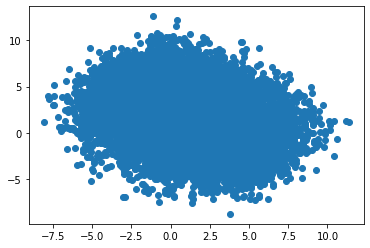

In [11]:
mean = encoder([u[:],v[:],p[:]])
print(mean.numpy().var(0))
print(sum(mean.numpy().var(0)))
plt.scatter(mean[:,0],mean[:,1])

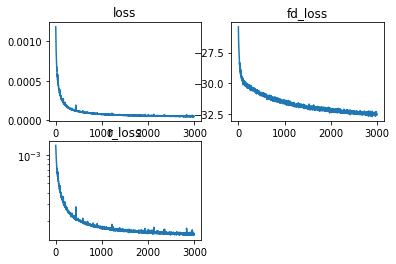

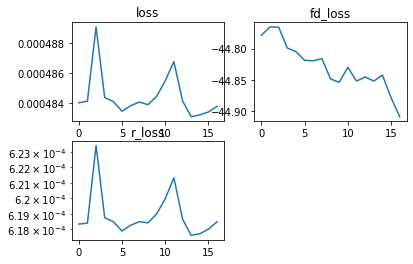

In [12]:

def plotHist(history,i_start = 0):
    plt.subplot(2,2,1)
    plt.plot(history.loss[i_start:])
    plt.title("loss")
    plt.subplot(2,2,2)
    plt.plot(history.fd_loss[i_start:])
    plt.title("fd_loss")
    plt.subplot(2,2,3)
    plt.plot(history.r_loss[i_start:])
    plt.title("r_loss")
    plt.gca().set_yscale('log')
    plt.show()

plotHist(history,3)
plotHist(historyL,3)

In [6]:
def Evaluate2(model,u,v,p,prob,n_batch=32):
    u_r,v_r,p_r = model([u,v,p])
    # mse_u,mse_v,mse_p = tf.reduce_mean(tf.square(u-u_r),axis=(0,1,2)),tf.reduce_mean(tf.square(v-v_r),axis=(0,1,2)),tf.reduce_mean(tf.square(p-p_r),axis=(0,1,2))
    mse_u,mse_v,mse_p = r_lossF([u,v,p,],[u_r,v_r,p_r],prob)
    mse_u,mse_v,mse_p = tf.sqrt(tf.reduce_mean(mse_u)),tf.sqrt(tf.reduce_mean(mse_v)),tf.sqrt(tf.reduce_mean(mse_p))
    u_res,v_res,con_res = tf.reduce_mean(u_res_loss(u_r,v_r,p_r,prob)),tf.reduce_mean(v_res_loss(u_r,v_r,p_r,prob)),tf.reduce_mean(con_res_loss(u_r,v_r,prob))
    return mse_u.numpy(),mse_v.numpy(),mse_p.numpy(),u_res.numpy(),v_res.numpy(),con_res.numpy()

model, encoder, decoder = GetAEStaggeredNL(input_shapes,n_latent,[[100],[100]])
model.load_weights("MLmodels/NS_10D_100_100")
mse_u,mse_v,mse_p,u_res,v_res,con_res = Evaluate2(model,u,v,p,prob)
print(mse_u,mse_v,mse_p,u_res,v_res,con_res)
# tf.keras.utils.plot_model(model, show_shapes=False)
modelL, encoderL, decoderL = GetAEStaggeredNL(input_shapes,n_latent,[[],[]])
modelL.load_weights("MLmodels/NS_10D__")
mse_u,mse_v,mse_p,u_res,v_res,con_res = Evaluate2(modelL,u,v,p,prob)
print(mse_u,mse_v,mse_p,u_res,v_res,con_res)
# tf.keras.utils.plot_model(model, show_shapes=False)

NameError: name 'input_shapes' is not defined

In [258]:
# model.save_weights("MLmodels/NS_10D_300_200200200")

In [145]:
mse_u,mse_v,mse_p,u_res,v_res,con_res = Evaluate2(model,u,v,p,prob)
print(mse_u,mse_v,mse_p,u_res,v_res,con_res)
mse_u,mse_v,mse_p,u_res,v_res,con_res = Evaluate2(modelL,u,v,p,prob)
print(mse_u,mse_v,mse_p,u_res,v_res,con_res)
#0.0606323 0.058109924 1.6100909 2.781433e-05 2.9239633e-05 4.3225995e-07
#0.07199982 0.07097976 1.9622935 2.2323218e-05 2.3344626e-05 3.8076816e-08
#0.072447665 0.071857594 1.860282 1.6549247e-05 1.8355842e-05 1.2554656e-07

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [255]:
model.save_weights("MLmodels/NS_10D__")

In [32]:
n_latent = 10
r_weights = [1/u.var(),1/v.var(),1/p.var()]
fd_weights = [0.003,0.03,0.05,0.08,0.1,0.3,0.5,1]
n_epochs = 10
n_batch = 128
u_in = u[:]
v_in = v[:]
p_in = p[:]
x = [u_in,v_in,p_in]
input_shapes = (u[0].shape,v[0].shape,p[0].shape)
prob = sf.GetProblem(30,1)

# model, encoder, decoder = GetAEStaggeredNL(input_shapes,n_latent,[[100],[100]])


def GetData(fd_weight,modelName):
    try:
        model.load_weights("MLmodels/"+modelName+"sweep/NS_10D_"+modelName+"fd"+str(fd_weight))
    except:
        print("Error loading fd_weight = "+str(fd_weight))
    optimizer = tf.keras.optimizers.Adam(0.001)
    history = train_VAE(model,optimizer,x,n_epochs,n_batch,prob,r_weights,fd_weight)
    print()
    # r_loss_arr.append(history.r_loss[-1])
    # fd_loss_arr.append(history.fd_loss[-1])
    # history_arr.append(history)
    model.save_weights("MLmodels/"+modelName+"sweep/NS_10D_"+modelName+"fd"+str(fd_weight))
    return history

def GetDatas(fd_weights,modelName):
    r_loss_arr = []
    fd_loss_arr = []
    history_arr = []
    for fd_weight in fd_weights:
        history = GetData(fd_weight,modelName)
        r_loss_arr.append(history.r_loss[-1])
        fd_loss_arr.append(history.fd_loss[-1])
        history_arr.append(history)
    return r_loss_arr,fd_loss_arr,history_arr

r_loss_arr,fd_loss_arr,history_arr = GetDatas(fd_weights,"NL2")

10/10 epochs - 99.8%; loss = 2.7728																																																																																																					
10/10 epochs - 99.8%; loss = 0.82607																																																																																																														
10/10 epochs - 99.8%; loss = -0.61767																																																																																														
10/10 epochs - 99.8%; loss = -2.7603																																																																																							
10/10 epochs - 99.8%; loss = -4.2453																																																																																																															
10/10 epochs - 99.8%; loss = -18.527																																																																																									
10/10 epochs - 99.8%; loss = -33.14																																																																																																							
10/10 epochs - 99.8%; loss = -69.125											

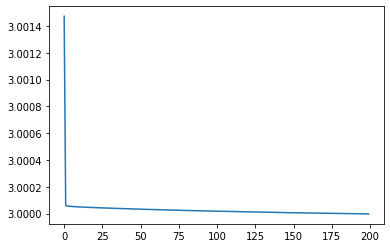

In [21]:
# plt.plot(history.r_loss)

100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


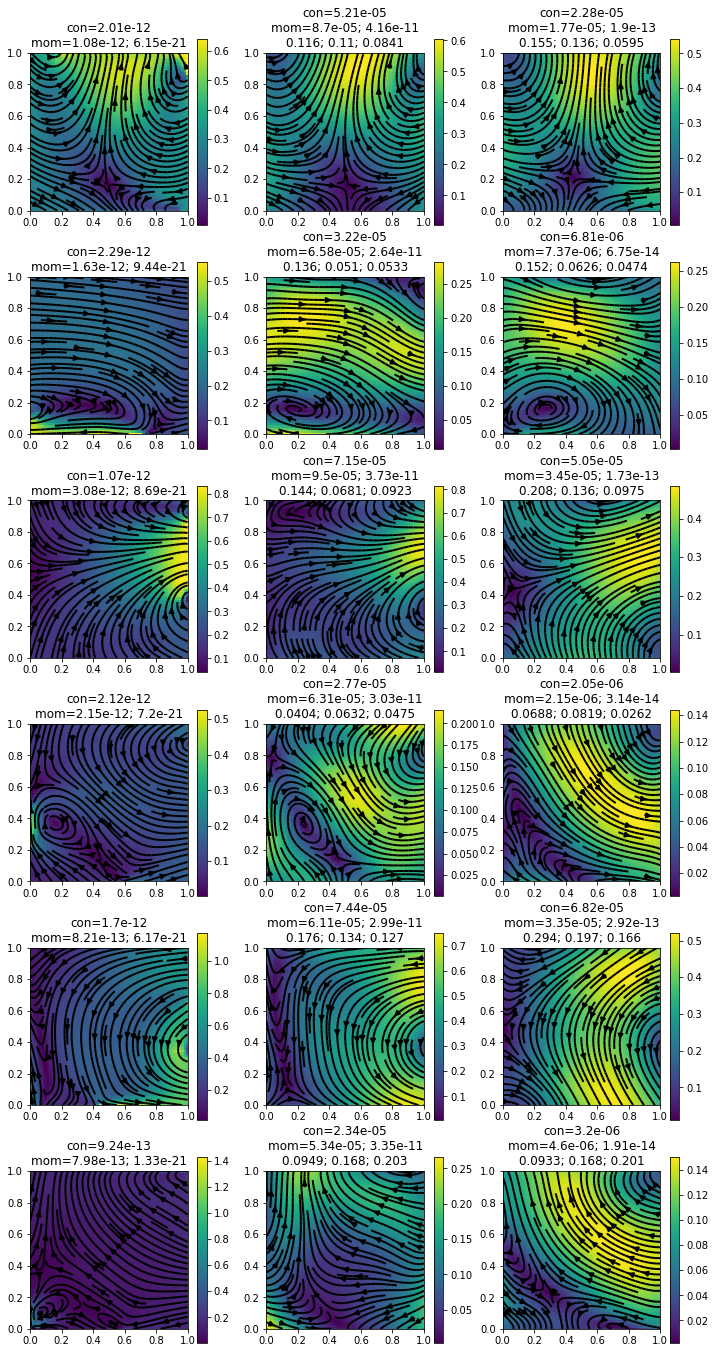

In [136]:
def PlotFlow(u,v,prob,ax):
    X_n,Y_n = np.meshgrid(prob.xc_u,prob.yc_v)
    u_n = (u[:,:-1]+u[:,1:])/2
    v_n = (v[:-1,:]+v[1:,:])/2
    u_n = np.transpose(u_n)
    v_n = np.transpose(v_n)
    X,Y = np.meshgrid(np.linspace(0,1,u_n.shape[0]*2),np.linspace(0,1,u_n.shape[1]*2))
    points_n = np.concatenate([X_n.reshape(X_n.size,1),Y_n.reshape(Y_n.size,1)],axis=1)
    values_n = np.concatenate([u_n.reshape(u_n.size,1),v_n.reshape(v_n.size,1)],axis=1)
    interp = LinearNDInterpolator(points_n, values_n)
    values_i = interp(X,Y)
    u_c = values_i[:,:,0]
    v_c = values_i[:,:,1]
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    c = ax.pcolormesh(X,Y,np.sqrt(u_c**2+v_c**2))
    plt.colorbar(c)
    ax.streamplot(X,Y,u_c,v_c,color="k",linewidth=2,density=1)
    plt.gca().set_aspect('equal', adjustable='box')

def Compare(n,model1,model2,u,v,p,prob):
    n = min(n,u.shape[0])
    u_r1,v_r1,p_r1 = model1([u[:n],v[:n],p[:n]])
    u_r1,v_r1,p_r1 = u_r1.numpy(),v_r1.numpy(),p_r1.numpy()
    u_r2,v_r2,p_r2 = model2([u[:n],v[:n],p[:n]])
    u_r2,v_r2,p_r2 = u_r2.numpy(),v_r2.numpy(),p_r2.numpy()
    # weights = np.array([1/u.var(),1/v.var(),1/p.var()])
    mse_u1,mse_v1,mse_p1 = np.square(u[:n]-u_r1).mean((1,2)),np.square(v[:n]-v_r1).mean((1,2)),np.square(p[:n]-p_r1).mean((1,2))
    mse_u2,mse_v2,mse_p2 = np.square(u[:n]-u_r2).mean((1,2)),np.square(v[:n]-v_r2).mean((1,2)),np.square(p[:n]-p_r2).mean((1,2))
    plt.figure(figsize=(12,4*n))
    for i in tqdm(range(n)):
        ax = plt.subplot(n,3,3*i+1)
        PlotFlow(u[i],v[i],prob,ax)
        ax.title.set_text("con={:.3g}\nmom={:.3g}; {:.3g}".format(float(u_res_loss(u[i:i+1],v[i:i+1],p[i:i+1],prob)),float(v_res_loss(u[i:i+1],v[i:i+1],p[i:i+1],prob)),float(con_res_loss(u[i:i+1],v[i:i+1],prob))))
        ax = plt.subplot(n,3,3*i+2)
        PlotFlow(u_r1[i],v_r1[i],prob,ax)
        ax.title.set_text("con={:.3g}\nmom={:.3g}; {:.3g}\n{:.3g}; {:.3g}; {:.3g}".format(float(u_res_loss(u_r1[i:i+1],v_r1[i:i+1],p_r1[i:i+1],prob)),float(v_res_loss(u_r1[i:i+1],v_r1[i:i+1],p_r1[i:i+1],prob)),float(con_res_loss(u_r1[i:i+1],v_r1[i:i+1],prob)),np.sqrt(mse_u1[i]),np.sqrt(mse_v1[i]),np.sqrt(mse_p1[i])))
        ax = plt.subplot(n,3,3*i+3)
        PlotFlow(u_r2[i],v_r2[i],prob,ax)
        ax.title.set_text("con={:.3g}\nmom={:.3g}; {:.3g}\n{:.3g}; {:.3g}; {:.3g}".format(float(u_res_loss(u_r2[i:i+1],v_r2[i:i+1],p_r2[i:i+1],prob)),float(v_res_loss(u_r2[i:i+1],v_r2[i:i+1],p_r2[i:i+1],prob)),float(con_res_loss(u_r2[i:i+1],v_r2[i:i+1],prob)),np.sqrt(mse_u2[i]),np.sqrt(mse_v2[i]),np.sqrt(mse_p2[i])))
    plt.show()

# index = 20
# modelPathNL = "MLmodels/NS_10D_NLv4"
# modelNL, encoderNL, decoderNL = GetAEStaggeredNL(input_shapes,n_latent)
# modelNL.load_weights(modelPathNL)
# u_r,v_r,p_r = modelNL([u[index:index+1],v[index:index+1],p[index:index+1]])
# af.PlotFlow(u[index],v[index],prob)
# af.PlotFlow(u_r[0],v_r[0],prob)
# print(af.CalcContinuityResiduals(u_r[0].numpy(),v_r[0].numpy(),prob),af.CalcMomentumResiduals(u_r[0].numpy(),v_r[0].numpy(),p_r[0].numpy(),prob))
# u_r,v_r,p_r = model([u[index:index+1],v[index:index+1],p[index:index+1]])
# af.PlotFlow(u_r[0],v_r[0],prob)
# print(af.CalcContinuityResiduals(u_r[0].numpy(),v_r[0].numpy(),prob),af.CalcMomentumResiduals(u_r[0].numpy(),v_r[0].numpy(),p_r[0].numpy(),prob))

index = 0
Compare(6,model,modelL,u[index:index+100],v[index:index+100],p[index:index+100],prob)

In [23]:
mean = encoder([u[:1000],v[:1000],p[:1000]])
mean.numpy().var(0)

array([0.00313048, 0.00086733, 0.00080454, 0.00134084, 0.00214979,
       0.00238084, 0.00234918, 0.00235429, 0.002691  , 0.00182309],
      dtype=float32)